In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import tensorflow as tf
from flask import Flask, request, jsonify
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from joblib import dump, load
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout
from keras.models import Sequential, save_model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2

provide training file as data.csv

provide glove file as glove.6B.100d.txt

run spacy, nltk commands

https://github.com/keras-team/keras/issues/18913

In [3]:
random_state = 42
test_size = 0.2
epochs = 6

In [4]:
def preprocess_data(df):
    df['type'] = df['type'].apply(lambda x: 1 if x == 'question' else 0)

    # Define a function to clean the text
    def clean_text(text):
        text = re.sub(r'\d+', '', text)  # remove digits
        text = text.translate(str.maketrans('', '', string.punctuation.replace('?', '')))  # remove punctuation except '?'
        text = text.lower()  # convert to lowercase
        text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespaces

        # filter out the stopwords except for interrogative words
        stop_words = set(stopwords.words('english')) - set(['what', 'where', 'when', 'why', 'how', 'which', 'who'])
        tokens = word_tokenize(text)
        filtered_text = [word for word in tokens if word not in stop_words]
        return ' '.join(filtered_text)

    # Apply the function to the text column
    df['text'] = df['text'].apply(clean_text)

    return df

df = pd.read_csv('data.csv', header=None, names=['id','text', 'type'], skiprows=1)
df.drop(labels='id', axis=1, inplace=True)

df = preprocess_data(df)

In [5]:
# Apply TF-IDF vectorization
def apply_tfidf(df):
    return TfidfVectorizer().fit_transform(df['text'])

X_tfidf = apply_tfidf(df)

# Apply LSA on TF-IDF vectors
def apply_lsa(X_tfidf):
    return TruncatedSVD(n_components=100).fit_transform(X_tfidf)

X_lsa = apply_lsa(apply_tfidf(df))

# Apply LDA on TF-IDF vectors
def apply_lda(X_tfidf):
    return LatentDirichletAllocation(n_components=10, n_jobs = -1).fit_transform(X_tfidf)

X_lda = apply_lda(apply_tfidf(df))

# Generate glove vectors
def vectorize_glove(df):
    embeddings_index = {}

    with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    def sentence_vector(sentence):
        words = sentence.split()
        word_vectors = [embeddings_index.get(word, np.zeros((100,))) for word in words]
        return np.mean(word_vectors, axis=0)

    return df['text'].apply(sentence_vector)

df['glove_vector'] = vectorize_glove(df)

# Generate doc2vec vectors
def vectorize_doc2vec(df):
    # Prepare the data for Doc2Vec
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['text'].apply(lambda x: x.split(' ')))]

    # Train a Doc2Vec model
    model = Doc2Vec(documents, vector_size=100, window=2, min_count=1)

    # Generate sentence vectors
    return df['text'].apply(lambda x: model.infer_vector(x.split(' ')))

df['doc2vec_vector'] = vectorize_doc2vec(df)

c:\Users\Rishi Vora\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Rishi Vora\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
# Logistic Regression
def train_lr(df):
    df['doc2vec_vector'] = vectorize_doc2vec(df)
    
    # Split the data into training and testing sets
    X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(df['doc2vec_vector'].tolist(), df['type'], test_size=test_size, random_state=random_state)

    # Train a logistic regression model
    clf_lr = LogisticRegression(penalty='l2', random_state=random_state, n_jobs=-1).fit(X_train_lr, y_train_lr)
    dump(clf_lr, 'model_lr.joblib') 

    return clf_lr, X_train_lr, X_test_lr, y_train_lr, y_test_lr

clf_lr, X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_lr(df)

# Evaluate the model
y_pred_lr = clf_lr.predict(X_test_lr)
print(classification_report(y_test_lr, y_pred_lr))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79     20604
           1       0.83      0.88      0.85     26418

    accuracy                           0.83     47022
   macro avg       0.83      0.82      0.82     47022
weighted avg       0.83      0.83      0.83     47022



In [17]:
# Logistic Regression
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(df['text'], df['type'], test_size=test_size, random_state=random_state)

# Define a pipeline
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(penalty='l2', random_state=random_state, n_jobs=-1))
])

# Now you can fit and predict using this pipeline as you would with a single estimator
clf_lr = pipeline_lr.fit(X_train_lr, y_train_lr)
dump(pipeline_lr, 'model_lr.pkl')

y_pred_lr = pipeline_lr.predict(X_test_lr)
print(classification_report(y_test_lr, y_pred_lr))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     20604
           1       0.97      0.97      0.97     26418

    accuracy                           0.97     47022
   macro avg       0.97      0.97      0.97     47022
weighted avg       0.97      0.97      0.97     47022



In [7]:
# Random Forests
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(df['text'], df['type'], test_size=test_size, random_state=random_state)

# Define a pipeline
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=random_state, n_jobs=-1))
])

# Now you can fit and predict using this pipeline as you would with a single estimator
clf_rf = pipeline_rf.fit(X_train_rf, y_train_rf)
dump(pipeline_rf, 'model_rf.pkl')

y_pred_rf = pipeline_rf.predict(X_test_rf)
print(classification_report(y_test_rf, y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     20604
           1       0.96      0.98      0.97     26418

    accuracy                           0.97     47022
   macro avg       0.97      0.96      0.96     47022
weighted avg       0.97      0.97      0.97     47022



In [8]:
# Data preparation for LSTM and Bi LSTM
def prepare_lstm_data(df):
    # Tokenize and pad sequences
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['text'])
    sequences = tokenizer.texts_to_sequences(df['text'])
    data_lstm = pad_sequences(sequences, maxlen=100)

    # Prepare the labels
    le = LabelEncoder()
    labels_lstm = le.fit_transform(df['type'])

    return data_lstm, labels_lstm, tokenizer

data_lstm, labels_lstm, tokenizer = prepare_lstm_data(df)

In [9]:
# LSTM
def train_lstm(df):
    data_lstm, labels_lstm, tokenizer = prepare_lstm_data(df)
    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(data_lstm, labels_lstm, test_size=test_size, random_state=random_state)

    # Build the LSTM model
    model_lstm = Sequential()
    model_lstm.add(Embedding(len(tokenizer.word_index) + 1, 100, trainable=False))
    model_lstm.add(LSTM(128))
    model_lstm.add(Dense(1, activation='sigmoid'))
    model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history_lstm = model_lstm.fit(X_train_lstm, y_train_lstm, validation_data=(X_test_lstm, y_test_lstm), epochs=epochs, batch_size=128)
    model_lstm.save('model_lstm.keras')

    return model_lstm, history_lstm, X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm

model_lstm, history_lstm, X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_lstm(df)

# Evaluate the model
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test_lstm, y_test_lstm)
print('Test Loss: {}'.format(loss_lstm))
print('Test Accuracy: {}'.format(accuracy_lstm))

Epoch 1/6
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 238s 161ms/step - accuracy: 0.8232 - loss: 0.4001 - val_accuracy: 0.9255 - val_loss: 0.1846
Epoch 2/6
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 245s 167ms/step - accuracy: 0.9362 - loss: 0.1608 - val_accuracy: 0.9614 - val_loss: 0.1124
Epoch 3/6
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 237s 162ms/step - accuracy: 0.9639 - loss: 0.1073 - val_accuracy: 0.9673 - val_loss: 0.0977
Epoch 4/6
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 238s 162ms/step - accuracy: 0.9680 - loss: 0.0976 - val_accuracy: 0.9707 - val_loss: 0.0898
Epoch 5/6
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 241s 164ms/step - accuracy: 0.9715 - loss: 0.0873 - val_accuracy: 0.9719 - val_loss: 0.0867
Epoch 6/6
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 242s 165ms/step - accuracy: 0.9733 - loss: 0.0819 - val_accuracy: 0.9714 - val_loss: 0.0890
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9713 - loss: 0.0890
Test Loss: 0.08897387236356735
Test Accuracy: 0.9713751077651978


In [10]:
# Bidirectional LSTM
def train_bilstm(df):
    data_bilstm, labels_bilstm, tokenizer = prepare_lstm_data(df)
    X_train_bilstm, X_test_bilstm, y_train_bilstm, y_test_bilstm = train_test_split(data_bilstm, labels_bilstm, test_size=test_size, random_state=random_state)

    # Build the Bidirectional LSTM model with L2 regularization
    model_bilstm = Sequential()
    model_bilstm.add(Embedding(input_dim=5000, output_dim=64))
    model_bilstm.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
    model_bilstm.add(Dropout(0.5))
    model_bilstm.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
    model_bilstm.add(Dropout(0.5))
    model_bilstm.add(Dense(1, activation='sigmoid'))

    model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history_bilstm = model_bilstm.fit(X_train_bilstm, y_train_bilstm, validation_data=(X_test_bilstm, y_test_bilstm), epochs=epochs, batch_size=128)
    # model_bilstm.save('model_bilstm.keras')

    return model_bilstm, history_bilstm, X_train_bilstm, X_test_bilstm, y_train_bilstm, y_test_bilstm

model_bilstm, history_bilstm, X_train_bilstm, X_test_bilstm, y_train_bilstm, y_test_bilstm = train_bilstm(df)

# Evaluate the model
loss_bilstm, accuracy_bilstm = model_bilstm.evaluate(X_test_bilstm, y_test_bilstm)
print('Test Loss: {}'.format(loss_bilstm))
print('Test Accuracy: {}'.format(accuracy_bilstm))

Epoch 1/6
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 486s 327ms/step - accuracy: 0.9081 - loss: 2.5708 - val_accuracy: 0.9742 - val_loss: 0.1948
Epoch 2/6
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 496s 337ms/step - accuracy: 0.9773 - loss: 0.1586 - val_accuracy: 0.9748 - val_loss: 0.1428
Epoch 3/6
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 514s 350ms/step - accuracy: 0.9781 - loss: 0.1322 - val_accuracy: 0.9756 - val_loss: 0.1360
Epoch 4/6
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 533s 363ms/step - accuracy: 0.9787 - loss: 0.1234 - val_accuracy: 0.9764 - val_loss: 0.1446
Epoch 5/6
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 551s 375ms/step - accuracy: 0.9800 - loss: 0.1162 - val_accuracy: 0.9753 - val_loss: 0.1432
Epoch 6/6
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 567s 386ms/step - accuracy: 0.9796 - loss: 0.1147 - val_accuracy: 0.9758 - val_loss: 0.1205
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.9766 - loss: 0.1195
Test Loss: 0.12051146477460861
Test Accuracy: 0.975756049156189


In [11]:
# Load models
# clf_lr = load('model_lr.joblib')
# clf_rf = load('model_rf.joblib')
# model_lstm = load_model('model_lstm.keras')
# model_bilstm = load_model('model_bilstm.keras')

# Get the prediction probabilities
lr_probs = clf_lr.predict_proba(X_test_lr)[:, 1]
rf_probs = clf_rf.predict_proba(X_test_rf)[:, 1]
lstm_probs = model_lstm.predict(X_test_lstm).ravel()
bilstm_probs = model_bilstm.predict(X_test_lstm).ravel()

# Compute the ROC curves
lr_fpr, lr_tpr, _ = roc_curve(y_test_lr, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test_rf, rf_probs)
lstm_fpr, lstm_tpr, _ = roc_curve(y_test_lstm, lstm_probs)
bilstm_fpr, bilstm_tpr, _ = roc_curve(y_test_lstm, bilstm_probs)

1470/1470 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step


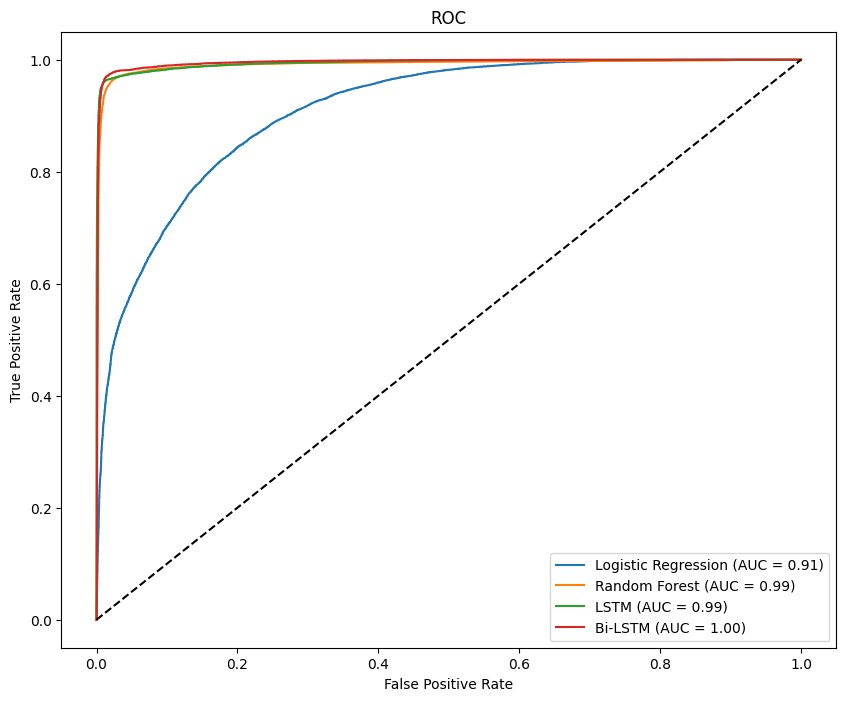

In [12]:
# Plot the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)' % auc(lr_fpr, lr_tpr))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = %0.2f)' % auc(rf_fpr, rf_tpr))
plt.plot(lstm_fpr, lstm_tpr, label='LSTM (AUC = %0.2f)' % auc(lstm_fpr, lstm_tpr))
plt.plot(bilstm_fpr, bilstm_tpr, label='Bi-LSTM (AUC = %0.2f)' % auc(bilstm_fpr, bilstm_tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

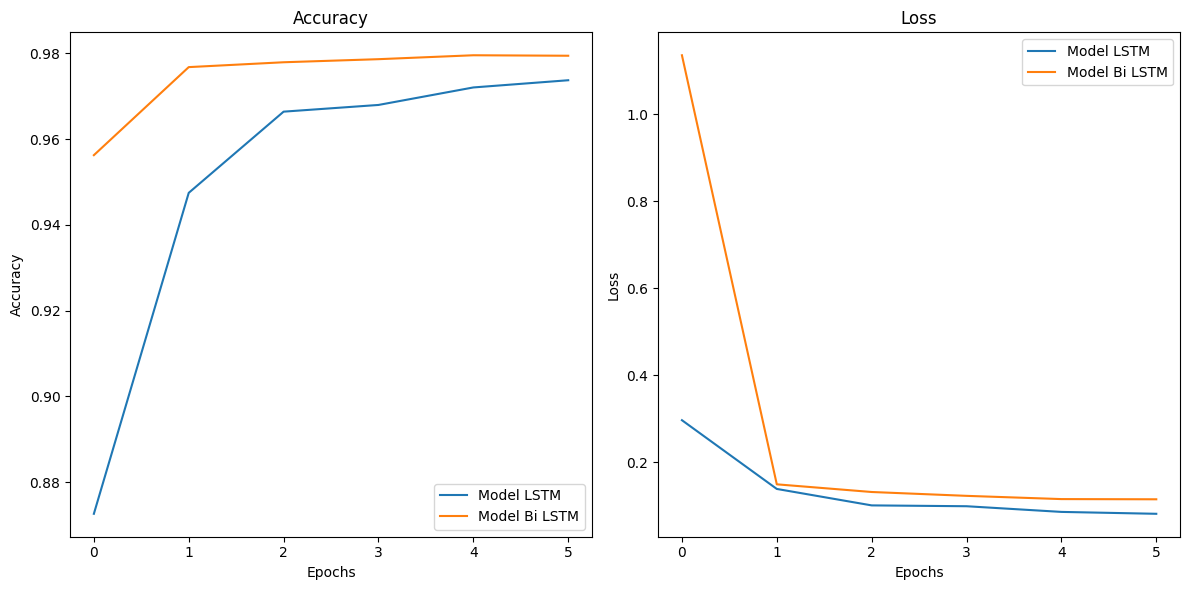

In [16]:
import matplotlib.pyplot as plt

# Assuming `history1`, `history2`, `history3` and `history4` are the history objects of your four models
plt.figure(figsize=(12,6))

# Plotting accuracy
plt.subplot(1, 2, 1)
# plt.plot(clf_lr.history['accuracy'], label='Model 1')
# plt.plot(clf_rf.history['accuracy'], label='Model 2')
plt.plot(history_lstm.history['accuracy'], label='Model LSTM')
plt.plot(history_bilstm.history['accuracy'], label='Model Bi LSTM')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
# plt.plot(clf_lr.history['loss'], label='Model 1')
# plt.plot(clf_rf.history['loss'], label='Model 2')
plt.plot(history_lstm.history['loss'], label='Model LSTM')
plt.plot(history_bilstm.history['loss'], label='Model Bi LSTM')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    model_type = data['model_type']
    input_data = np.array(data['input_data'])

    model_dict = {
        'lr': 'model_lr.joblib',
        'rf': 'model_rf.joblib',
        'lstm': 'model_lstm.keras',
        'bilstm': 'model_bilstm.keras'
    }

    model_file = model_dict.get(model_type)
    if model_file is None:
        return jsonify({'error': 'Invalid model type'})

    if model_type in ['lstm', 'bilstm']:
        model = load_model(model_file)
    else:
        model = load(model_file)

    prediction = model.predict(input_data)
    return jsonify({'prediction': prediction.tolist()})

@app.route('/train', methods=['POST'])
def train():
    data = request.get_json(force=True)
    model_type = data['model_type']
    X_train = np.array(data['X_train'])
    y_train = np.array(data['y_train'])

    df = pd.DataFrame({'text': X_train, 'type': y_train})
    df = preprocess_data(df)

    model_dict = {
        'lr': train_lr,
        'rf': train_rf,
        'lstm': train_lstm,
        'bi_lstm': train_bilstm
    }

    model = model_dict.get(model_type)

    if model is None:
        return jsonify({'error': 'Invalid model type'})
    
    trained_model, X_train, X_test, y_train, y_test = model(df)

    return jsonify({'message': 'Model trained and saved. Now you can make predictions.'})

if __name__ == '__main__':
    app.run(port=2745, debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:2745
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

In [66]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the data
df = pd.read_csv('data.csv', header=None, names=['id','text', 'type'], skiprows=1)  # replace with your csv file path
df.drop(labels='id', axis=1, inplace=True)

df = preprocess_data(df)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['type'], test_size=0.2, random_state=42)

# Create a pipeline that vectorizes the text data, then trains a Random Forest classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
predictions = pipeline.predict(X_test)
print(classification_report(y_test, predictions))

# Function to predict from a single input
def predict_from_input(input_text):
    return pipeline.predict([input_text])

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     20604
           1       0.97      0.98      0.97     26418

    accuracy                           0.97     47022
   macro avg       0.97      0.97      0.97     47022
weighted avg       0.97      0.97      0.97     47022

[0]


In [81]:
print(predict_from_input("Python dictionaries are mutable, which means that you can add, delete, or modify key-value pairs in a dictionary. "))

[0]
